<a href="https://colab.research.google.com/github/santiagogutierrezreina/IA/blob/main/Clasificador_de_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importamos librerias
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
#Obtenemos el dataset de fashion mnist con las 60.000 imagenes de entrenamiento y 10.000 de test
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.DXKWWT_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.DXKWWT_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr

In [4]:
#Separamos los datos de entrenamiento y prueba
datos_entrenamiento = datos['train']
datos_pruebas = datos['test']

In [5]:
#Obtenemos las etiquetas
nombres_clases = metadatos.features['label'].names

In [6]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
#Normalizamos los datos entre 0-1
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32) #Transforma imagenes a un dato tipo float32
  imagenes /= 255                          #La divide entre 255 para normalizarla de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizamos los datos de entrenamiento y test
datos_entrenamiento = datos_entrenamiento.map(normalizar) #.map aplica la funcion interna a cada elemento del dataset
datos_pruebas = datos_pruebas.map(normalizar)

#Agregamos a cache(memoria en lugar de disco)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

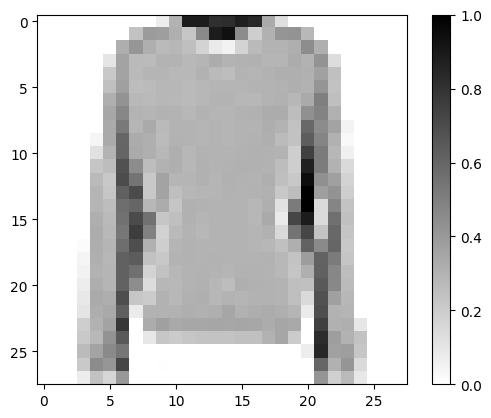

In [8]:
#Mostrar una imagen de los datos de prueba
for imagen, etiqueta in datos_entrenamiento.take(1): #De momento, solo se imprime la primer imagen
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionamos la imagen a 28x28

#Dibuja la imagen asi, ay que bonito
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)

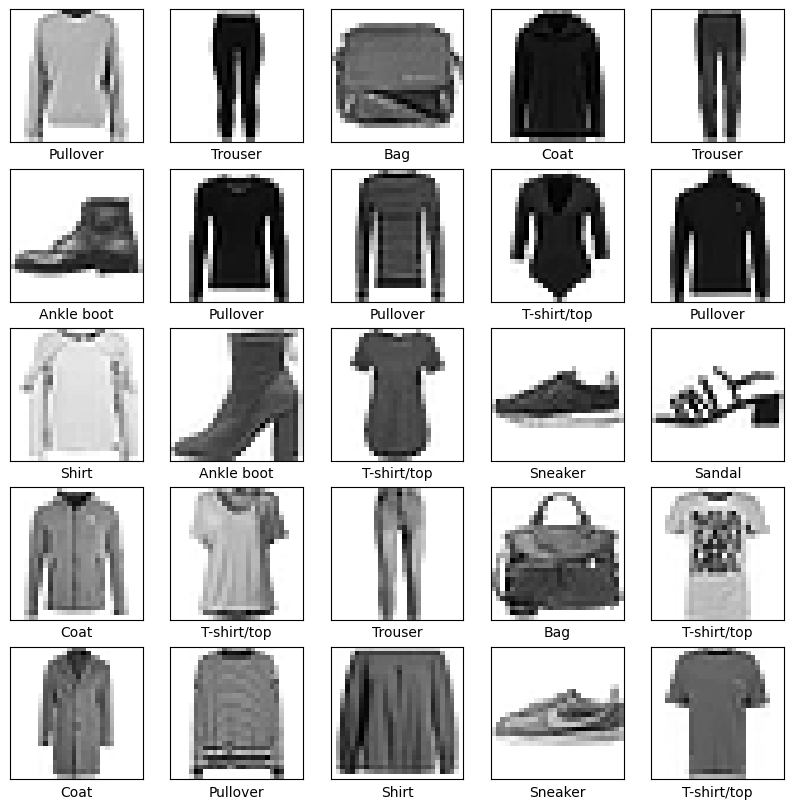

In [9]:
plt.figure(figsize=(10,10)) #Crea una figura de 10"x 10"
for i , (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)): #Crea un contador con los 25 datos
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1) #Crea una matriz 5x5 donde se almacena cada imagen creada con su etiqueta

  #Limpiamos ticks y grilla
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  #Muestra la imagen en la escala de grises y la etiqueta en el xlabel
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [10]:
#Creamos el modelo
modelo = tf.keras.Sequential([
    #Creamos la capa entrada (Flatten "aplasta" a una sola dimension)
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro

    #Creamos las capas ocultas densas, con 50 neuronas y la funcion reLU
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),

    #softmax se emplea para aplicar la funcion de activacion en la capa de salida, para las redes de clasificacion, asegurando que siempre la salida sea 1
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #10 - numero de clases
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
#Compilamos el modelo
modelo.compile(
    optimizer='adam', #Optimizador
    loss='sparse_categorical_crossentropy', #Funcion de perdida
    metrics=['accuracy'] #Metrica
)

In [12]:
#Guardamos en variables la cantidad de datos de entrenamiento y pruebas
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [13]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [14]:
#Definimos en lotes para no sobrecargar el modelo con la cantidad de datos de prueba
TAMANO_LOTE = 32

#Separamos los datos en los batches o lotes
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE) #Repetimos los datos de entrenamiento de forma aleatoria
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [15]:
import math

#Entrenamos el modelo con 5 vueltas, idealmente debe llegar a nna precision del 88%
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE)) #steps-per-epoch va a ser removida, por ende no es relevante

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7629 - loss: 0.6865
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8540 - loss: 0.4012
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8687 - loss: 0.3536
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8791 - loss: 0.3261
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8853 - loss: 0.3101


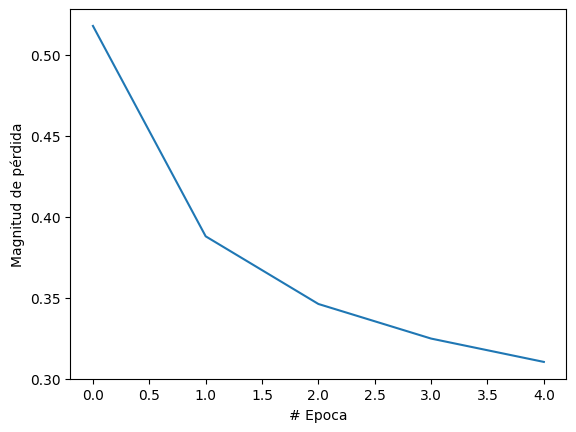

In [16]:
#Graficamos la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


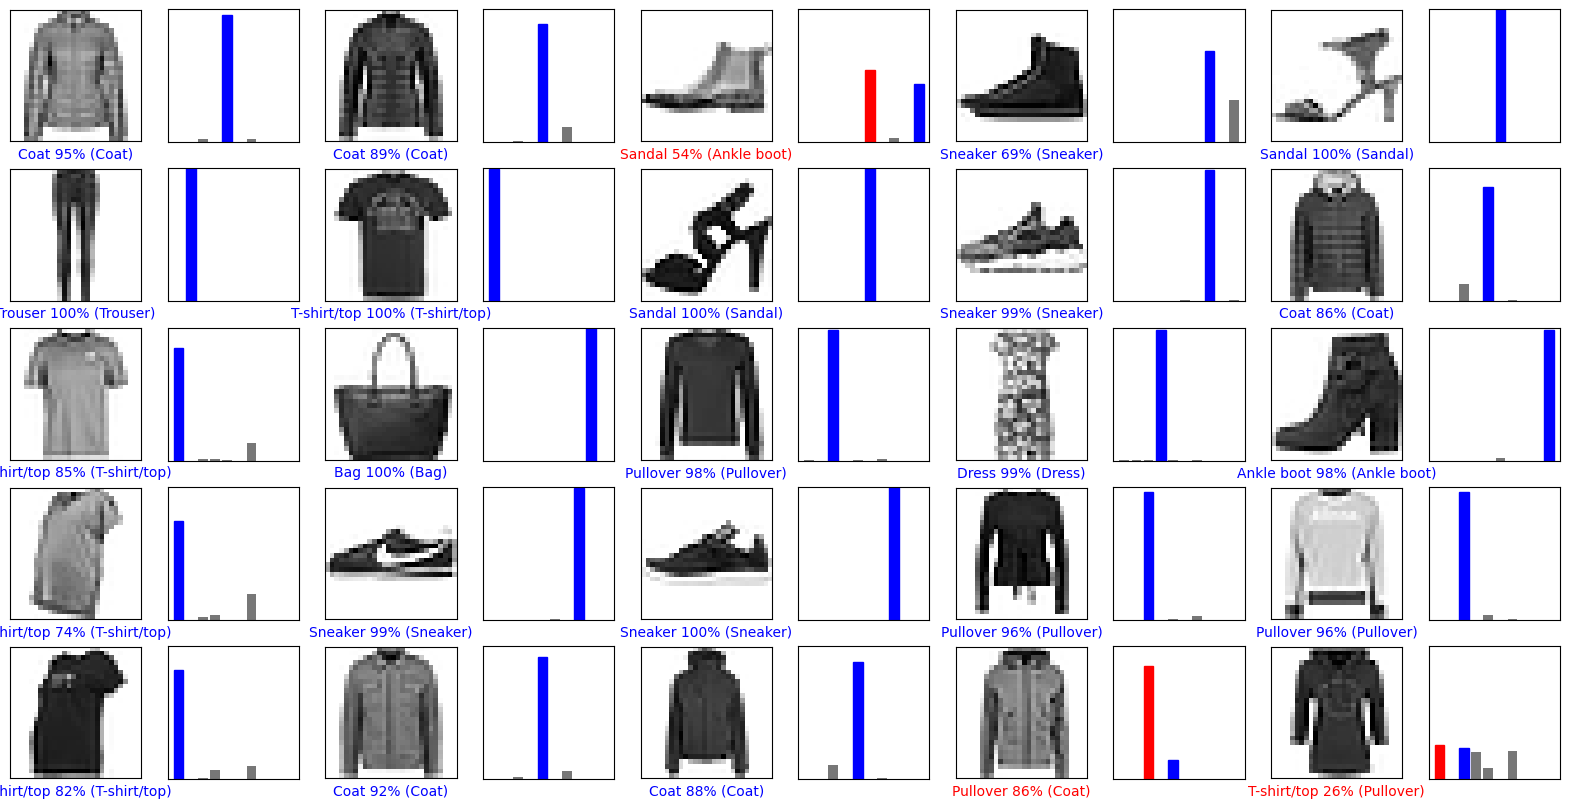

In [17]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [18]:
#Tomar cualquier dato para realizar una prediccion
imagen = imagenes_prueba[0]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prediccion: Coat
